In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from analysis import *
from ema_workbench import load_results

In [9]:
# Load results
results = load_results('../results/scenarios=3000, policies=0.tar.gz')

In [10]:
outcomes = prepare_outcomes_dataframe(results)
experiments = results[0]

## Examine consumption recovery 

In [7]:
districts = [
    'AnseLaRayeCanaries',
    'Castries',
    'Choiseul',
    'Dennery',
    'Gros Islet',
    'Laborie',
    'Micoud',
    'Soufriere',
    'Vieuxfort'
]

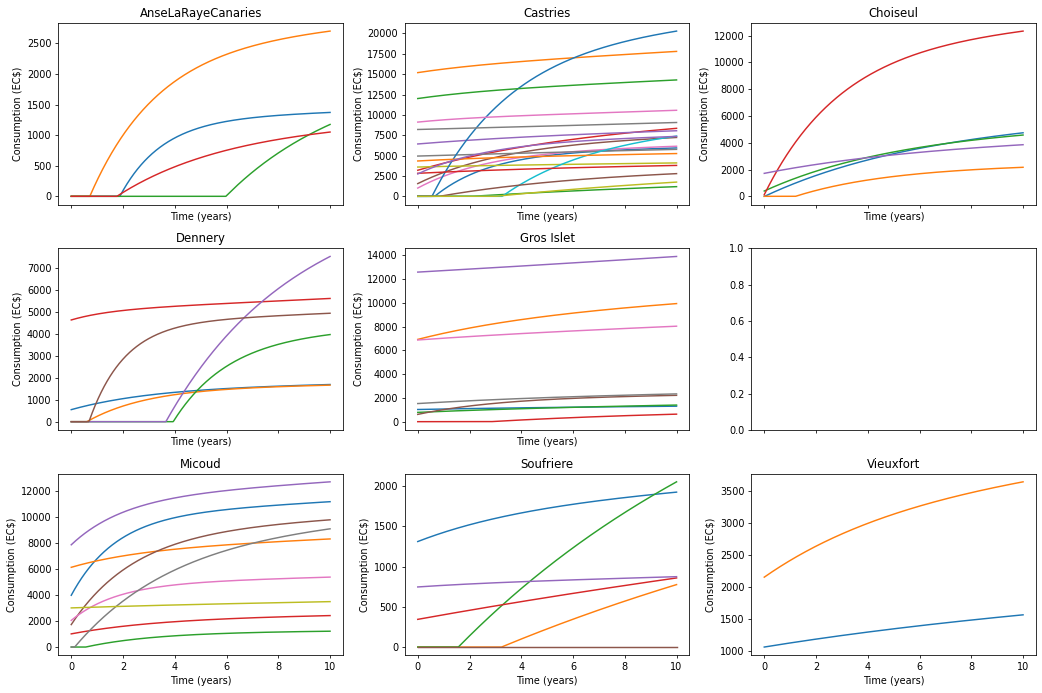

In [34]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6 * 2.5, 4 * 2.5), sharey=False, sharex=True)

colors = sns.color_palette('Set1', len(districts))

for i, district in enumerate(districts):
    r = pkl.load(open(f'../src/{district}.pkl', 'rb'))
    n = r[0].shape[0]
    for j in range(n):
        x = []
        y = []
        for key, values in r.items():
            y.append(values[j])
            x.append(key)
        ax[i // 3, i % 3].plot(x, y)
        ax[i // 3, i % 3].set_xlabel('Time (years)')
        ax[i // 3, i % 3].set_ylabel('Consumption (EC$)')
        ax[i // 3, i % 3].set_title(f'{district}')
fig.tight_layout()

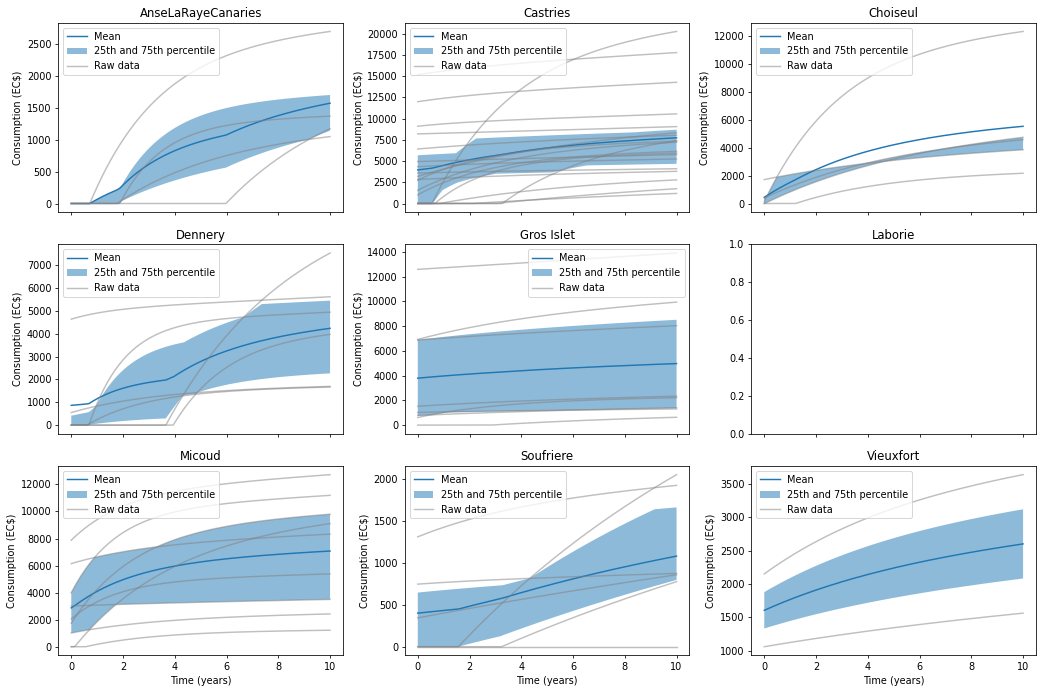

In [33]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6 * 2.5, 4 * 2.5), sharey=False, sharex=True)

colors = sns.color_palette('Set1', len(districts))

for i, district in enumerate(districts):
    r = pkl.load(open(f'../src/{district}.pkl', 'rb'))
    n = r[0].shape[0]
    l = []
    if n == 0:
        ax[i // 3, i % 3].set_title(f'{district}')
        continue
    
    for j in range(n):
        x = []
        y = []
        for key, values in r.items():
            y.append(values[j])
            x.append(key)
        l.append(y)
    df = pd.DataFrame(l).T
    df.index = x
    q1 = df.quantile(0.25, axis=1)
    q3 = df.quantile(0.75, axis=1)
    ax[i // 3, i % 3].plot(x, df.mean(axis=1))
    ax[i // 3, i % 3].fill_between(x, q1, q3, alpha=0.5)
    df.plot(ax=ax[i // 3, i % 3], legend=False, color='gray', alpha=0.5)
    ax[i // 3, i % 3].set_xlabel('Time (years)')
    ax[i // 3, i % 3].set_ylabel('Consumption (EC$)')
    ax[i // 3, i % 3].set_title(f'{district}')
    ax[i // 3, i % 3].legend(['Mean', '25th and 75th percentile', 'Raw data'])
    
fig.tight_layout()

## Plot outcomes

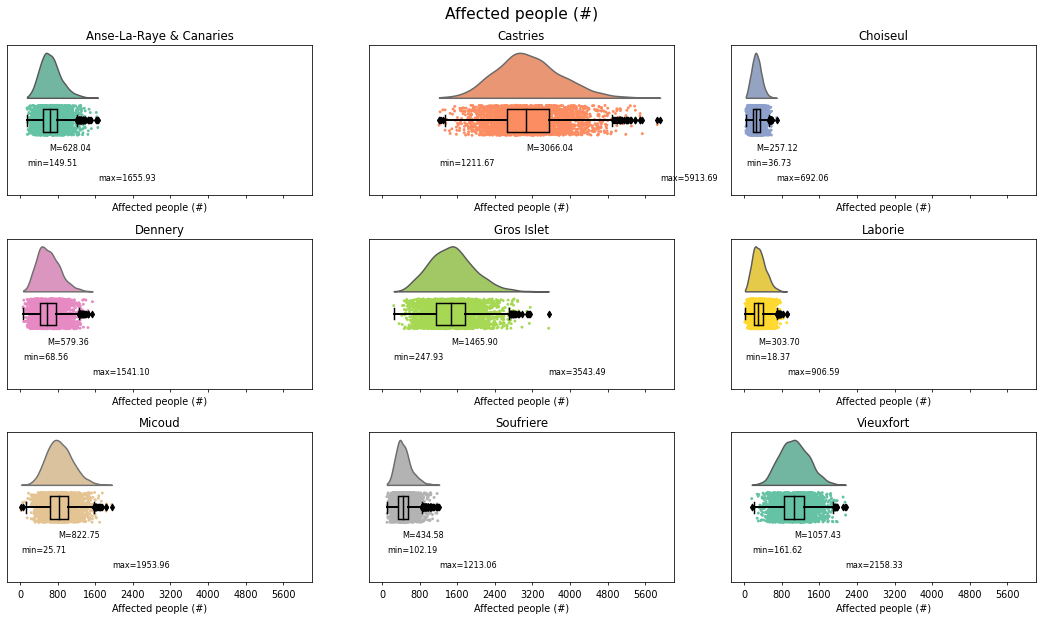

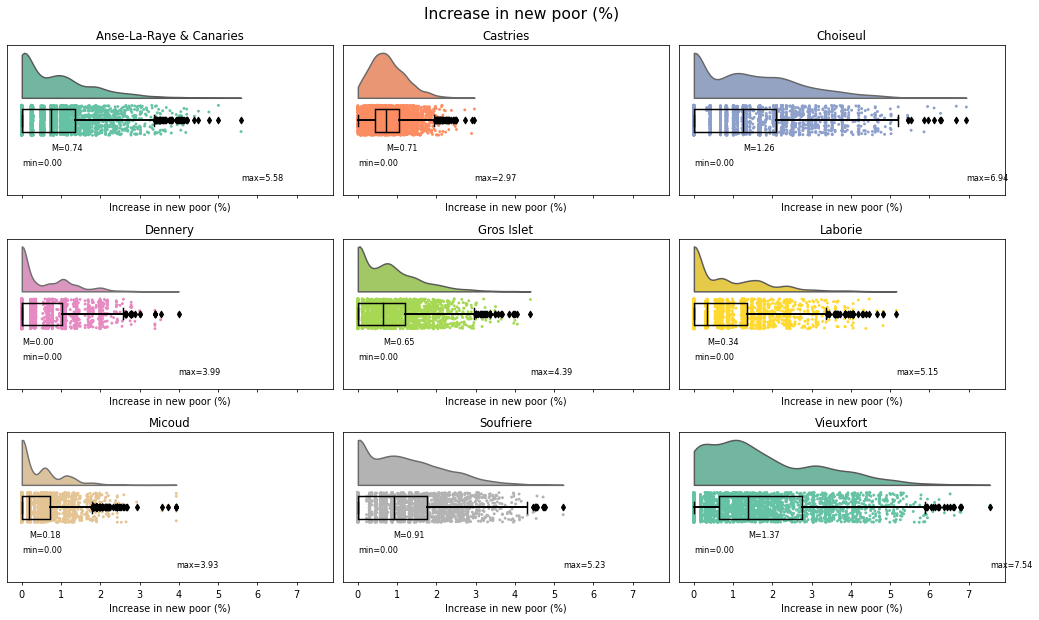

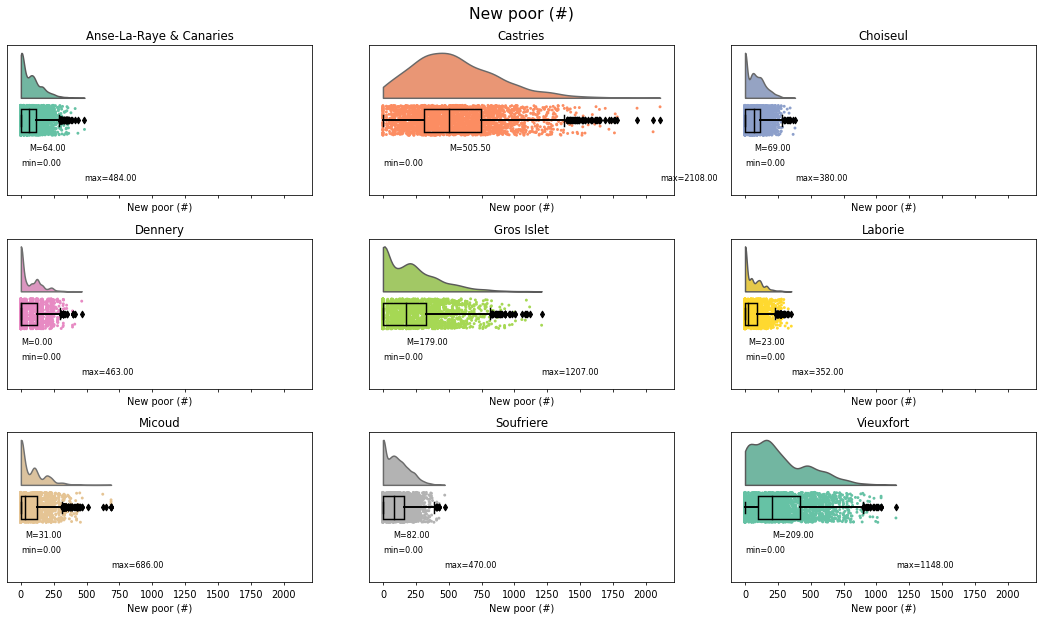

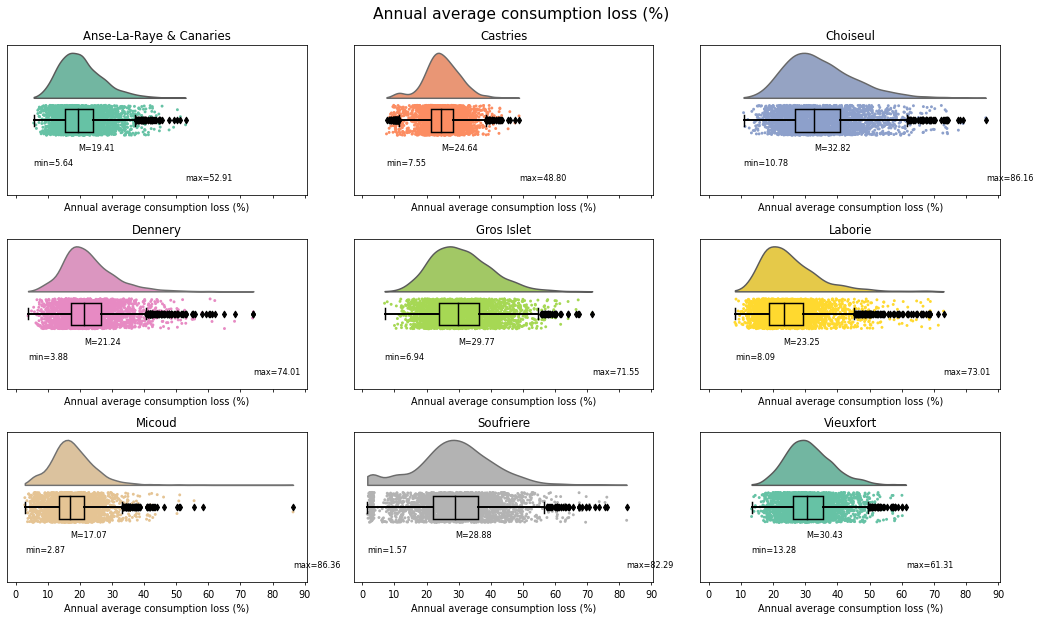

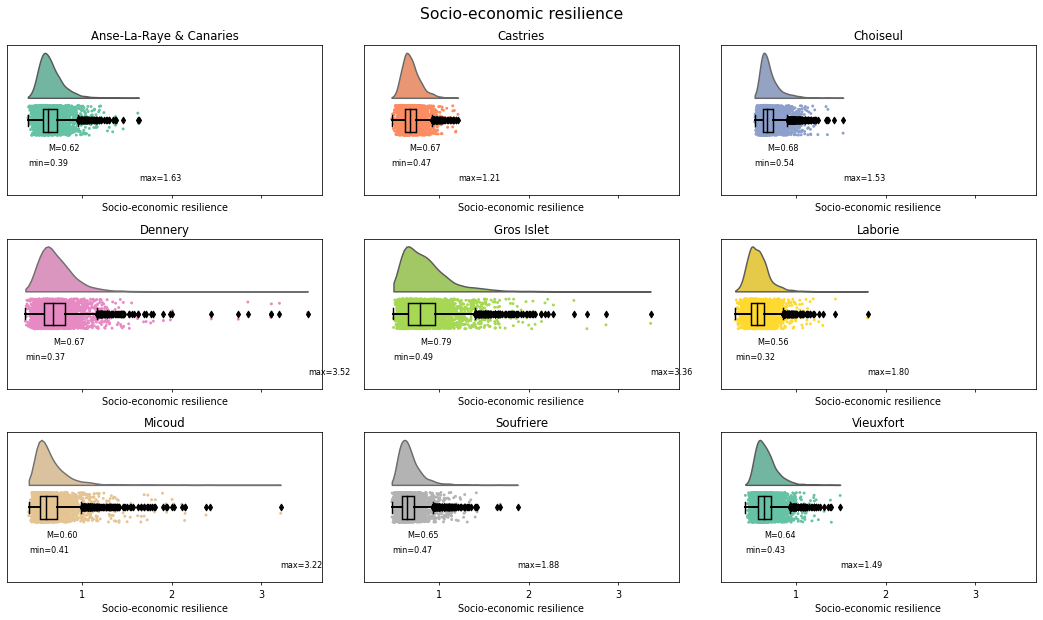

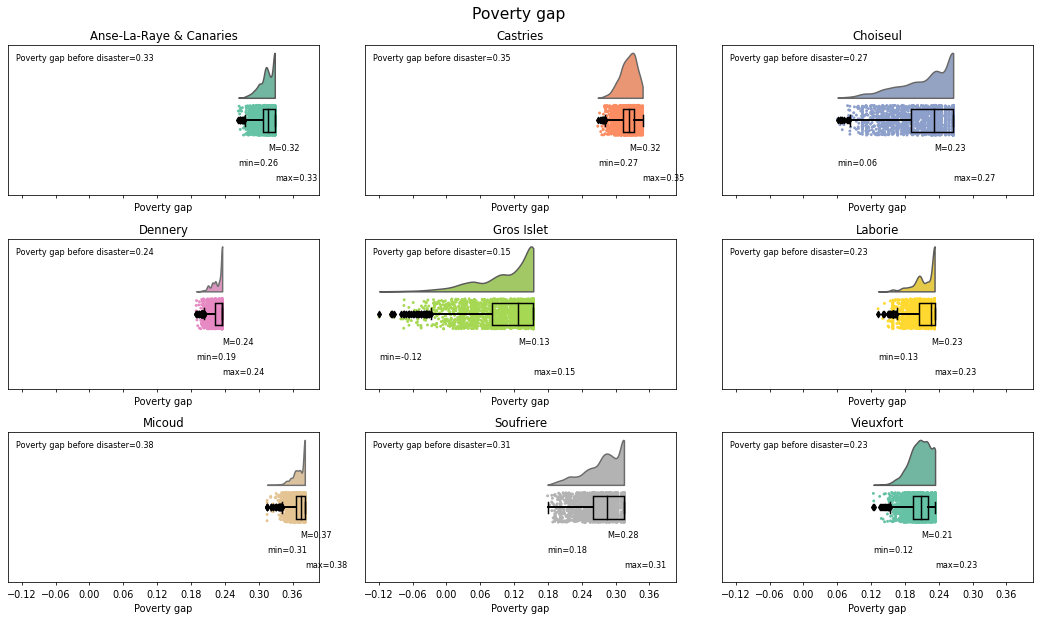

In [21]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
colors = sns.color_palette('Set2', n_colors=len(districts))

x_columns = [
    'n_affected_people',
    'n_new_poor_increase_pct', 
    'n_new_poor', 
    'annual_average_consumption_loss_pct', 
    'r',
    'new_poverty_gap',
    # 'one_year_in_poverty',
    # 'two_years_in_poverty',
    # 'three_years_in_poverty',
    # 'four_years_in_poverty',
    # 'five_years_in_poverty',
    # 'six_years_in_poverty',
    # 'seven_years_in_poverty',
    # 'eight_years_in_poverty',
    # 'nine_years_in_poverty',
    # 'ten_years_in_poverty'
    ]
x_titles = [
    'Affected people (#)',
    'Increase in new poor (%)', 
    'New poor (#)', 
    'Annual average consumption loss (%)', 
    'Socio-economic resilience',
    'Poverty gap',
    # 'One year in poverty',
    # 'Two years in poverty',
    # 'Three years in poverty',
    # 'Four years in poverty',
    # 'Five years in poverty',
    # 'Six years in poverty',
    # 'Seven years in poverty',
    # 'Eight years in poverty',
    # 'Nine years in poverty',
    # 'Ten years in poverty'
    ]

is_years_in_poverty = False

for x_column, x_title in zip(x_columns, x_titles):
    # if x_column == 'new_poor_increase_pct' or x_column == 'annual_average_consumption_loss_pct':
    #     sharex = True
    # else:
    #     sharex = False
    sharex = True
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True)

    for district in districts:
        df = outcomes[outcomes['district'] == district]
        
        # Calculate % increase in new poor in respect to the initial number of poor
        # df = df.assign(new_poor_increase_pct = df['new_poor'].div(df['poor_initial']).multiply(100))

        # Calculate an increase in new poor in respect to the total population
        df = df.assign(n_new_poor_increase_pct = df['n_new_poor'].div(df['total_population']).multiply(100))
        df = df.assign(annual_average_consumption_loss_pct = df['annual_average_consumption_loss_pct'].multiply(100))
        # df = df.assign(one_year_in_poverty = df['years_in_poverty'].apply(lambda x: x[0]))
        # df = df.assign(two_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[1]))
        # df = df.assign(three_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[2]))
        # df = df.assign(four_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[3]))
        # df = df.assign(five_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[4]))
        # df = df.assign(six_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[5]))
        # df = df.assign(seven_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[6]))
        # df = df.assign(eight_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[7]))
        # df = df.assign(nine_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[8]))
        # df = df.assign(ten_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[9]))

        df[x_column] = df[x_column].astype(float)

        # Make a half violin plot
        pt.half_violinplot(x=x_column, 
                        y='policy', # hue='scenario',
                        data=df,
                        color=colors[districts.index(district)],
                        bw=.2, 
                        cut=0.,
                        scale="area", 
                        width=.6, 
                        inner=None,
                        ax=ax[districts.index(district) // 3, districts.index(district) % 3])
        
        # Add stripplot
        sns.stripplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color=colors[districts.index(district)],
                    edgecolor='white',
                    size=3,
                    jitter=1,
                    zorder=0,
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        # Add boxplot
        sns.boxplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color="black", 
                    width=.15, 
                    zorder=10,
                    showcaps=True, 
                    boxprops={'facecolor':'none', "zorder":10},
                    showfliers=True, 
                    whiskerprops={'linewidth':2, "zorder":10},
                    saturation=1, 
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        if district == 'AnseLaRayeCanaries':
            district_name = 'Anse-La-Raye & Canaries'
        else:
            district_name = district
        
        if is_years_in_poverty:
            title = district_name + ', E = ' + f'{round(df[x_column].mean())}'
        else:
            title = district_name
        ax[districts.index(district) // 3, districts.index(district) % 3].set_title(title)
        ax[districts.index(district) // 3, districts.index(district) % 3].set_ylabel('')
        ax[districts.index(district) // 3, districts.index(district) % 3].set_xlabel(x_title)

        # Remove x-axis labels
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticklabels([])
        # Remove y-axis ticks
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticks([])

        # Do not display floats in the x-axis
        ax[districts.index(district) // 3, districts.index(district) % 3].xaxis.set_major_locator(MaxNLocator(integer=True))

        # Plot the median
        # ax[districts.index(district) // 3, districts.index(district) % 3].axvline(df[x_column].median(), color='black', linestyle='--', linewidth=1)
        # Add text close to the boxplot's median
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].median(), 0.2, 
                                                                               f'M={df[x_column].median():.2f}', 
                                                                               horizontalalignment='left', size='small', color='black')
        
        # Add text close to the boxplot's min and max
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].min(), 0.3,
                                                                                 f'min={df[x_column].min():.2f}', 
                                                                                 horizontalalignment='left', size='small', color='black')
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].max(), 0.4,
                                                                                    f'max={df[x_column].max():.2f}', 
                                                                                    horizontalalignment='left', size='small', color='black')
        
        initial_poverty_gap = df['initial_poverty_gap'].iloc[0]
        # Add initial poverty gap as in the legend to the plot
        if x_column == 'new_poverty_gap':
            ax[districts.index(district) // 3, districts.index(district) % 3].text(0.025, 0.9,
                                                                                 f'Poverty gap before disaster={initial_poverty_gap:.2f}', 
                                                                                 horizontalalignment='left', size='small', color='black',
                                                                                 transform=ax[districts.index(district) // 3, districts.index(district) % 3].transAxes)
        

    # Add a super title
    fig.suptitle(x_title, fontsize=16)
    fig.tight_layout()
    # plt.savefig(f'../figures/analysis/{x_column}.png', dpi=300, bbox_inches='tight')

In [12]:
from collections import defaultdict
years_in_poverty = {}
for district in outcomes['district'].unique():
    df = outcomes[outcomes['district'] == district]
    result = defaultdict(int)
    for i, row in df.iterrows():
        d = row['years_in_poverty']
        for k, v in d.items():
            result[k] += v
    years_in_poverty[district] = result

In [15]:
pd.DataFrame(years_in_poverty).div(3000).multiply(100).round()

,AnseLaRayeCanaries,Castries,Choiseul,Dennery,Gros Islet,Laborie,Micoud,Soufriere,Vieuxfort
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,489.0,0.0,0.0,0.0,15.0,1.0,0.0,0.0
